****
# Introduction #
****
This Notebook's goal is to successfully classify Chinese Digits (15 of them to be precise)

If you liked this Notebook or if you found it helpful, Kindly Upvote and fork it :)


* **Accelerator: GPU P1000**
* **Language: Python**
* **Model Used: Convolutional Neural Network (CNN)**
* **Testing Accuracy Achieved: 98.4%**



****
# Dataset Description #
****
**Can also be found in the Data Card of this Dataset**

One hundred Chinese nationals took part in data collection. Each participant wrote with a standard black ink pen all 15 numbers in a table with 15 designated regions drawn on a white A4 paper. 

This process was repeated 10 times with each participant. Each sheet was scanned with a resolution of 300x300 pixels.

It resulted in a dataset of 15000 images, each representing one character from a set of 15 characters (grouped in samples, grouped in suites, with 10 samples/volunteer and 100 volunteers).

****
# Reading and Displaying the Data #
****

In [ ]:
# importing various
import pandas as pd
import numpy as np
import copy
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# importing kan
sys.path.append("/home/bunkir2004/Desktop/KAN/repositories/torch-conv-kan")
from kans.layers import KANLayer


In [2]:
df=pd.read_csv(r'/home/bunkir2004/Desktop/KAN/repositories/torch-conv-kan/data/chinese-mnist-digit-recognizer/chineseMNIST.csv') #Reading the data
df #Displaying the data

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,八
14996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,八
14997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,八
14998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,八


In [3]:
df.shape #checking the shape of the data

(15000, 4098)

****
# Preprocessing #
****

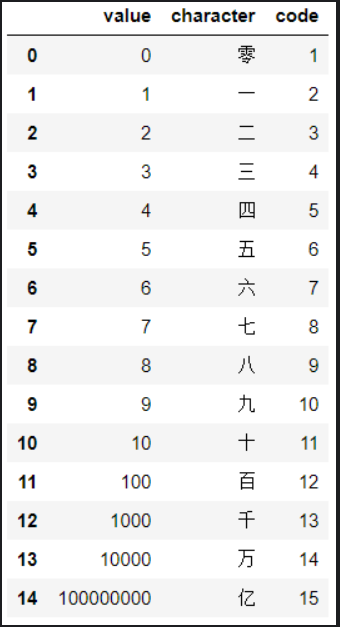

This are the values and its corresponding code

In [34]:
# Changing the values to the code for only some of the values
df['label'].replace(100,11,inplace=True)
df['label'].replace(1000,12,inplace=True)
df['label'].replace(10000,13,inplace=True)
df['label'].replace(100000000,14,inplace=True)

/tmp/ipykernel_226287/440117427.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].replace(100,11,inplace=True)
/tmp/ipykernel_226287/440117427.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [193]:
# The first 4096 columns contain the pixel values
# The 4097 column contains the code and the 4098th column cotains the corresponding character
x=df.iloc[:,:4096]  # x is our features or pixels (First 4096 columns)
y=df.iloc[:,4096:]  # y is our target variable or our code for the digits along with its character
print(x.shape,y.shape)

(15000, 4096) (15000, 2)


In [194]:
# First set us split the dataset into training and testing set in the ratio 70:30
# Second let us furthur split our testing set into testing and validation sets in the ratio 50:50

t_x,tes_x,t_y,tes_y=train_test_split(x,y,test_size=0.3,random_state=20) # Training and testing Split
val_x,te_x,val_y,te_y = train_test_split(tes_x, tes_y, test_size=0.5, random_state=20) # Testing and Validation Split
print(t_x.shape,t_y.shape,te_x.shape,te_y.shape,val_x.shape,val_y.shape)

(10500, 4096) (10500, 2) (2250, 4096) (2250, 2) (2250, 4096) (2250, 2)


In [195]:
# Our target variable contains two columns (label and Character)
# Our character column will come in handy during evaluation but for our model not that useful therefore let us go ahead and drop the character column :)
t_y=t_y.iloc[:,:1]
te_y=te_y.iloc[:,:1]
val_y=val_y.iloc[:,:1]
print(t_y.shape,te_y.shape,val_y.shape)

(10500, 1) (2250, 1) (2250, 1)


In [196]:
# Normalizing the pixel values
t_x=t_x.astype('float64')/255.0
te_x=te_x.astype('float64')/255.0
val_x=val_x.astype('float64')/255.0

In [197]:
# We have our pixels for each image as an array we need to reshape them into 2-D array and it has to be grayscale
# We need to first convert it to 1D, for that we use to_numpy() function
# Next We are basically converting these pixels into a 2-D 64 X 64 grayscale images
# We use the reshape function to do that
t_x=t_x.to_numpy().reshape(-1,64,64,1)
te_x=te_x.to_numpy().reshape(-1,64,64,1)
val_x=val_x.to_numpy().reshape(-1,64,64,1)
print(t_x.shape,te_x.shape,val_x.shape)

(10500, 64, 64, 1) (2250, 64, 64, 1) (2250, 64, 64, 1)


In [198]:
# We have our features (Pixels) shape in our desired format
# We need to one hot encode our Label column (Target variable)
# To apply one hot encoding we need our label shape to be (n,) but currently our Label column shape is (n,1) so we convert it by using squeeze() funciton
t_y=pd.get_dummies(t_y.squeeze())
te_y=pd.get_dummies(te_y.squeeze())
val_y=pd.get_dummies(val_y.squeeze())
print(t_y.shape,te_y.shape,val_y.shape)

(10500, 15) (2250, 15) (2250, 15)


****
# Displaying the Grayscale Images #
****

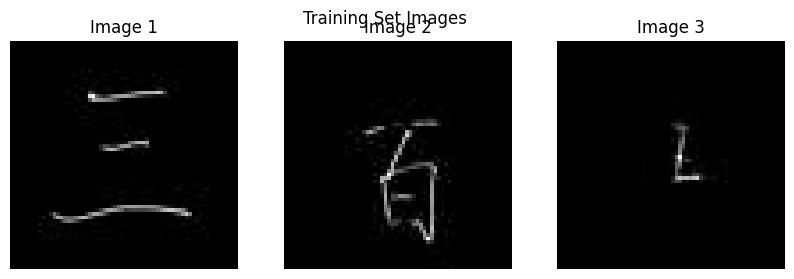

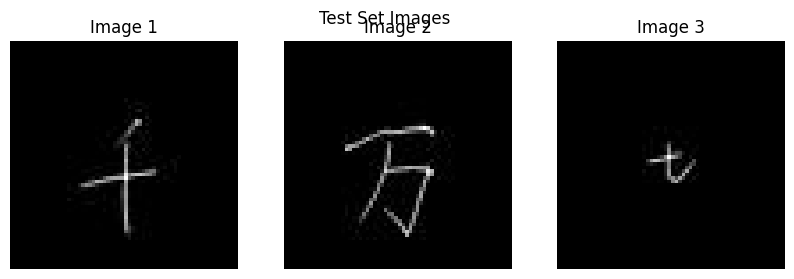

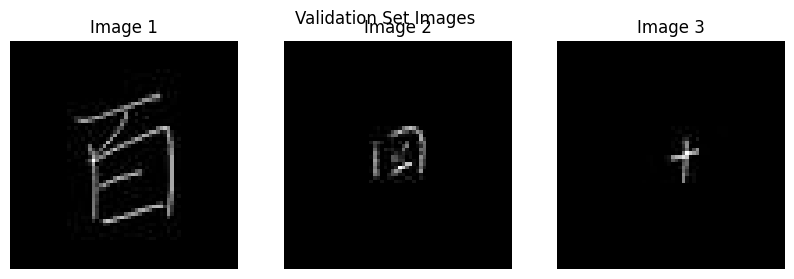

In [199]:
# Function to display images from a dataset
def display_images(dataset, title="Images"):
    plt.figure(figsize=(10, 3))  # Set the figure size
    for i in range(3):  # Display 3 images
        plt.subplot(1, 3, i+1)
        plt.imshow(dataset[i].reshape(64, 64), cmap='gray')  # Reshape to (64, 64) and plot in grayscale
        plt.axis('off')  # Hide axes
        plt.title(f"Image {i+1}")
    plt.suptitle(title)  # Add a title above the images
    plt.show()
# Display 3 images from each set
display_images(t_x, "Training Set Images")
display_images(te_x, "Test Set Images")
display_images(val_x, "Validation Set Images")


In [200]:
print(df['label'].nunique())
print(df['character'].nunique())

15
15


****
# CNN #
****

In [ ]:
class ChineseCharacterCNN(nn.Module):
    def __init__(self, add_kan: bool = False):
        super(ChineseCharacterCNN, self).__init__()

        self.save_dir = ''

        self.add_kan = add_kan
        
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kmodel_kanernel_size=2, stride=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.2)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(0.2)
        
        # Calculate the flattened size
        # After max pooling, the dimensions are halved: 64/2 = 32
        self.flattened_size = 32 * 32 * 32
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 128)
        self.bn6 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.5)
        
        # Output layer
        if add_kan:
            self.fc4 = KANLayer(128, 15)  # 15 classes
            self.save_name = 'best_kan_model.pth'
        else:
            self.fc4 = nn.Linear(128, 15)  # 15 classes
            self.save_name = 'best_linear_model.pth'

    def forward(self, x):
        # Fix input shape from [N,H,W,C] to [N,C,H,W]
        if x.shape[-1] == 1:  # If channels are last
            x = x.permute(0, 3, 1, 2)
        
        # First block
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.pool1(x)
        
        # Second block
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.dropout1(x)
        
        # Third block
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.dropout2(x)
        
        # Flatten
        x = x.contiguous().view(-1, self.flattened_size)
        
        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn4(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        x = self.bn5(x)
        x = self.dropout3(x)
        
        x = self.fc3(x)
        x = F.relu(x)
        x = self.bn6(x)
        x = self.dropout4(x)
        
        # Output layer (no softmax when using CrossEntropyLoss)
        x = self.fc4(x)

        return x

    def summary(self):
        # Print a summary similar to Keras model.summary()
        print(f"Model: {self.__class__.__name__}")
        print("_" * 65)
        print(f"{'Layer (type)':<25}{'Output Shape':<25}{'Param #':<15}")
        print("=" * 65)
        
        total_params = 0
        for name, parameter in self.named_parameters():
            param_count = parameter.numel()
            total_params += param_count
            layer_name = name.split('.')[0]
            output_shape = list(parameter.shape)
            print(f"{layer_name:<25}{str(output_shape):<25}{param_count:<15}")
        
        print("=" * 65)
        print(f"Total params: {total_params}")
        print("_" * 65)

In [214]:
model_kan = ChineseCharacterCNN(add_kan=True)
model_kan.summary()

Model: ChineseCharacterCNN
_________________________________________________________________
Layer (type)             Output Shape             Param #        
conv1                    [64, 1, 3, 3]            576            
conv1                    [64]                     64             
bn1                      [64]                     64             
bn1                      [64]                     64             
conv2                    [32, 64, 3, 3]           18432          
conv2                    [32]                     32             
bn2                      [32]                     32             
bn2                      [32]                     32             
conv3                    [32, 32, 3, 3]           9216           
conv3                    [32]                     32             
bn3                      [32]                     32             
bn3                      [32]                     32             
fc1                      [1024, 32768]           

In [213]:
model_linear = ChineseCharacterCNN(add_kan=False)
model_linear.summary()

Model: ChineseCharacterCNN
_________________________________________________________________
Layer (type)             Output Shape             Param #        
conv1                    [64, 1, 3, 3]            576            
conv1                    [64]                     64             
bn1                      [64]                     64             
bn1                      [64]                     64             
conv2                    [32, 64, 3, 3]           18432          
conv2                    [32]                     32             
bn2                      [32]                     32             
bn2                      [32]                     32             
conv3                    [32, 32, 3, 3]           9216           
conv3                    [32]                     32             
bn3                      [32]                     32             
bn3                      [32]                     32             
fc1                      [1024, 32768]           

In [207]:
t_x.shape, t_y.shape, te_x.shape, te_y.shape, val_x.shape, val_y.shape

((10500, 64, 64, 1),
 (10500, 15),
 (2250, 64, 64, 1),
 (2250, 15),
 (2250, 64, 64, 1),
 (2250, 15))

In [208]:
# Convert numpy arrays to PyTorch tensors
def numpy_to_tensor(x, y):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return x_tensor, y_tensor

# Assuming t_x, t_y, val_x, val_y are your numpy arrays
# Convert data to PyTorch tensors
train_x, train_y = numpy_to_tensor(t_x, np.argmax(t_y, axis=1))  # Convert one-hot to class indices
val_x, val_y = numpy_to_tensor(val_x, np.argmax(val_y, axis=1))
test_x, test_y = numpy_to_tensor(te_x, np.argmax(te_y, axis=1))

### Linear model training

In [215]:
# Create DataLoaders
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Initialize model
model = ChineseCharacterCNN(add_kan=False)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# define save dir
save_dir = 'runs'
os.makedirs(save_dir, exist_ok=True)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.005, patience=15)

# Training loop
best_val_acc = 0.0
patience = 15
no_improve = 0
epochs = 50

for epoch in tqdm(range(epochs), desc="PROCCESSING"):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Add channel dimension if needed (from 64x64 to 1x64x64)
        if len(inputs.shape) == 3:
            inputs = inputs.unsqueeze(1)
            
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            if len(inputs.shape) == 3:
                inputs = inputs.unsqueeze(1)
                
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total
    
    print(f'Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
    
    # Early stopping and learning rate reduction
    scheduler.step(val_acc)

    model_save_path = os.path.join(model.save_dir, model.save_name)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve = 0
        # Save best model weights
        print(model_save_path)
        torch.save(model.state_dict(), model_save_path)
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            # Load best model weights
            model.load_state_dict(torch.load(model_save_path))
            break

cuda


PROCCESSING:   2%|▏         | 1/50 [00:13<11:12, 13.73s/it]

Epoch 1: Train Loss: 1.1189, Train Acc: 65.75%, Val Loss: 21.1166, Val Acc: 16.44%
best_linear_model.pth


PROCCESSING:   4%|▍         | 2/50 [00:27<10:59, 13.74s/it]

Epoch 2: Train Loss: 0.3715, Train Acc: 88.33%, Val Loss: 11.0497, Val Acc: 31.42%
best_linear_model.pth


PROCCESSING:   6%|▌         | 3/50 [00:41<10:46, 13.75s/it]

Epoch 3: Train Loss: 0.2346, Train Acc: 93.27%, Val Loss: 1.3419, Val Acc: 86.27%
best_linear_model.pth


PROCCESSING:   8%|▊         | 4/50 [00:54<10:29, 13.69s/it]

Epoch 4: Train Loss: 0.1884, Train Acc: 94.27%, Val Loss: 81.1195, Val Acc: 12.44%


PROCCESSING:  10%|█         | 5/50 [01:08<10:16, 13.69s/it]

Epoch 5: Train Loss: 0.1747, Train Acc: 94.90%, Val Loss: 67.4259, Val Acc: 20.31%
Epoch 6: Train Loss: 0.1426, Train Acc: 95.69%, Val Loss: 0.1006, Val Acc: 96.98%
best_linear_model.pth


PROCCESSING:  14%|█▍        | 7/50 [01:36<09:52, 13.78s/it]

Epoch 7: Train Loss: 0.0822, Train Acc: 97.55%, Val Loss: 3.5547, Val Acc: 82.58%


PROCCESSING:  16%|█▌        | 8/50 [01:50<09:39, 13.80s/it]

Epoch 8: Train Loss: 0.2117, Train Acc: 93.59%, Val Loss: 0.1379, Val Acc: 96.84%


PROCCESSING:  18%|█▊        | 9/50 [02:03<09:26, 13.81s/it]

Epoch 9: Train Loss: 0.0948, Train Acc: 97.08%, Val Loss: 0.6790, Val Acc: 89.87%


PROCCESSING:  20%|██        | 10/50 [02:17<09:13, 13.83s/it]

Epoch 10: Train Loss: 0.0802, Train Acc: 97.76%, Val Loss: 0.2019, Val Acc: 95.29%


PROCCESSING:  22%|██▏       | 11/50 [02:31<09:02, 13.91s/it]

Epoch 11: Train Loss: 0.0854, Train Acc: 97.42%, Val Loss: 0.5025, Val Acc: 97.51%
best_linear_model.pth


PROCCESSING:  24%|██▍       | 12/50 [02:45<08:48, 13.91s/it]

Epoch 12: Train Loss: 0.0861, Train Acc: 97.38%, Val Loss: 3.4960, Val Acc: 85.38%


PROCCESSING:  26%|██▌       | 13/50 [02:59<08:37, 13.98s/it]

Epoch 13: Train Loss: 0.1290, Train Acc: 96.22%, Val Loss: 0.0778, Val Acc: 98.58%
best_linear_model.pth


PROCCESSING:  28%|██▊       | 14/50 [03:13<08:23, 13.98s/it]

Epoch 14: Train Loss: 0.0765, Train Acc: 97.91%, Val Loss: 0.0938, Val Acc: 98.49%


PROCCESSING:  30%|███       | 15/50 [03:28<08:12, 14.06s/it]

Epoch 15: Train Loss: 0.0615, Train Acc: 98.14%, Val Loss: 0.1375, Val Acc: 99.11%
best_linear_model.pth


PROCCESSING:  32%|███▏      | 16/50 [03:42<07:57, 14.05s/it]

Epoch 16: Train Loss: 0.0472, Train Acc: 98.49%, Val Loss: 0.0669, Val Acc: 98.49%


PROCCESSING:  34%|███▍      | 17/50 [03:56<07:43, 14.06s/it]

Epoch 17: Train Loss: 0.0465, Train Acc: 98.63%, Val Loss: 0.1228, Val Acc: 98.67%


PROCCESSING:  36%|███▌      | 18/50 [04:10<07:30, 14.07s/it]

Epoch 18: Train Loss: 0.0457, Train Acc: 98.58%, Val Loss: 0.1114, Val Acc: 98.13%


PROCCESSING:  38%|███▊      | 19/50 [04:24<07:16, 14.07s/it]

Epoch 19: Train Loss: 0.0482, Train Acc: 98.76%, Val Loss: 443.2269, Val Acc: 15.29%


PROCCESSING:  40%|████      | 20/50 [04:38<07:04, 14.15s/it]

Epoch 20: Train Loss: 0.0390, Train Acc: 98.71%, Val Loss: 2.0130, Val Acc: 78.98%


PROCCESSING:  42%|████▏     | 21/50 [04:53<06:51, 14.20s/it]

Epoch 21: Train Loss: 0.0524, Train Acc: 98.44%, Val Loss: 2.3806, Val Acc: 83.07%


PROCCESSING:  44%|████▍     | 22/50 [05:07<06:40, 14.30s/it]

Epoch 22: Train Loss: 0.0432, Train Acc: 98.62%, Val Loss: 0.0904, Val Acc: 98.58%


PROCCESSING:  46%|████▌     | 23/50 [05:23<06:35, 14.63s/it]

Epoch 23: Train Loss: 0.0491, Train Acc: 98.74%, Val Loss: 4.0950, Val Acc: 92.09%


PROCCESSING:  48%|████▊     | 24/50 [05:37<06:20, 14.65s/it]

Epoch 24: Train Loss: 0.0501, Train Acc: 98.51%, Val Loss: 0.1003, Val Acc: 98.89%


PROCCESSING:  50%|█████     | 25/50 [05:52<06:07, 14.69s/it]

Epoch 25: Train Loss: 0.0542, Train Acc: 98.47%, Val Loss: 0.4523, Val Acc: 96.04%


PROCCESSING:  52%|█████▏    | 26/50 [06:07<05:51, 14.63s/it]

Epoch 26: Train Loss: 0.0850, Train Acc: 97.40%, Val Loss: 1.7542, Val Acc: 93.91%


PROCCESSING:  54%|█████▍    | 27/50 [06:22<05:39, 14.77s/it]

Epoch 27: Train Loss: 0.0618, Train Acc: 98.10%, Val Loss: 0.1252, Val Acc: 98.98%


PROCCESSING:  56%|█████▌    | 28/50 [06:36<05:24, 14.73s/it]

Epoch 28: Train Loss: 0.0770, Train Acc: 97.92%, Val Loss: 0.1129, Val Acc: 97.11%


PROCCESSING:  58%|█████▊    | 29/50 [06:51<05:11, 14.81s/it]

Epoch 29: Train Loss: 0.0984, Train Acc: 96.76%, Val Loss: 0.0944, Val Acc: 98.09%


PROCCESSING:  58%|█████▊    | 29/50 [07:06<05:08, 14.70s/it]

Epoch 30: Train Loss: 0.0627, Train Acc: 98.36%, Val Loss: 0.0539, Val Acc: 98.44%
Early stopping after 30 epochs


### KAN model training

In [211]:
# Create DataLoaders
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Initialize model
model = ChineseCharacterCNN(add_kan=True)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# define save dir
save_dir = 'runs'
os.makedirs(save_dir, exist_ok=True)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.005, patience=15)

# Training loop
best_val_acc = 0.0
patience = 15
no_improve = 0
epochs = 50

for epoch in tqdm(range(epochs), desc="PROCCESSING"):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Add channel dimension if needed (from 64x64 to 1x64x64)
        if len(inputs.shape) == 3:
            inputs = inputs.unsqueeze(1)
            
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            if len(inputs.shape) == 3:
                inputs = inputs.unsqueeze(1)
                
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total
    
    print(f'Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
    
    # Early stopping and learning rate reduction
    scheduler.step(val_acc)

    model_save_path = os.path.join(model.save_dir, model.save_name)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve = 0
        # Save best model weights
        print(model_save_path)
        torch.save(model.state_dict(), model_save_path)
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            # Load best model weights
            model.load_state_dict(torch.load(model_save_path))
            break

cuda


PROCCESSING:   2%|▏         | 1/50 [00:15<12:34, 15.40s/it]

Epoch 1: Train Loss: 1.6499, Train Acc: 53.44%, Val Loss: 3.0210, Val Acc: 11.33%
best_kan_model.pth


PROCCESSING:   4%|▍         | 2/50 [00:30<12:16, 15.34s/it]

Epoch 2: Train Loss: 0.6631, Train Acc: 85.38%, Val Loss: 0.6539, Val Acc: 82.40%
best_kan_model.pth


PROCCESSING:   6%|▌         | 3/50 [00:45<11:53, 15.18s/it]

Epoch 3: Train Loss: 0.3765, Train Acc: 92.18%, Val Loss: 3.8816, Val Acc: 6.84%


PROCCESSING:   8%|▊         | 4/50 [01:00<11:40, 15.22s/it]

Epoch 4: Train Loss: 0.2926, Train Acc: 93.57%, Val Loss: 0.1557, Val Acc: 96.53%
best_kan_model.pth


PROCCESSING:  10%|█         | 5/50 [01:16<11:25, 15.23s/it]

Epoch 5: Train Loss: 0.2050, Train Acc: 95.64%, Val Loss: 3.8528, Val Acc: 9.73%


PROCCESSING:  12%|█▏        | 6/50 [01:31<11:12, 15.27s/it]

Epoch 6: Train Loss: 0.4157, Train Acc: 88.69%, Val Loss: 3.4857, Val Acc: 26.53%


PROCCESSING:  14%|█▍        | 7/50 [01:47<10:58, 15.32s/it]

Epoch 7: Train Loss: 0.2188, Train Acc: 94.48%, Val Loss: 0.2444, Val Acc: 92.58%


PROCCESSING:  16%|█▌        | 8/50 [02:02<10:45, 15.37s/it]

Epoch 8: Train Loss: 0.2076, Train Acc: 94.50%, Val Loss: 0.1887, Val Acc: 95.42%


PROCCESSING:  18%|█▊        | 9/50 [02:17<10:31, 15.39s/it]

Epoch 9: Train Loss: 0.1476, Train Acc: 96.37%, Val Loss: 0.1476, Val Acc: 96.53%
Epoch 10: Train Loss: 0.1504, Train Acc: 96.13%, Val Loss: 0.1098, Val Acc: 97.69%
best_kan_model.pth


PROCCESSING:  22%|██▏       | 11/50 [02:49<10:03, 15.47s/it]

Epoch 11: Train Loss: 0.0987, Train Acc: 97.83%, Val Loss: 0.1242, Val Acc: 97.02%


PROCCESSING:  24%|██▍       | 12/50 [03:04<09:46, 15.45s/it]

Epoch 12: Train Loss: 0.0865, Train Acc: 98.00%, Val Loss: 0.1092, Val Acc: 97.16%
Epoch 13: Train Loss: 0.0980, Train Acc: 97.67%, Val Loss: 0.0864, Val Acc: 97.87%
best_kan_model.pth


PROCCESSING:  28%|██▊       | 14/50 [03:35<09:21, 15.59s/it]

Epoch 14: Train Loss: 0.0862, Train Acc: 97.83%, Val Loss: 0.0564, Val Acc: 98.44%
best_kan_model.pth


PROCCESSING:  30%|███       | 15/50 [03:51<09:02, 15.50s/it]

Epoch 15: Train Loss: 0.0705, Train Acc: 98.30%, Val Loss: 0.4173, Val Acc: 89.91%


PROCCESSING:  32%|███▏      | 16/50 [04:06<08:47, 15.51s/it]

Epoch 16: Train Loss: 0.0644, Train Acc: 98.36%, Val Loss: 0.3576, Val Acc: 92.13%


PROCCESSING:  34%|███▍      | 17/50 [04:22<08:32, 15.53s/it]

Epoch 17: Train Loss: 0.0885, Train Acc: 97.54%, Val Loss: 0.1599, Val Acc: 95.56%


PROCCESSING:  36%|███▌      | 18/50 [04:37<08:17, 15.55s/it]

Epoch 18: Train Loss: 0.0990, Train Acc: 97.16%, Val Loss: 0.2317, Val Acc: 93.73%


PROCCESSING:  38%|███▊      | 19/50 [04:53<08:02, 15.57s/it]

Epoch 19: Train Loss: 0.0768, Train Acc: 97.95%, Val Loss: 0.0961, Val Acc: 97.56%


PROCCESSING:  40%|████      | 20/50 [05:09<07:47, 15.58s/it]

Epoch 20: Train Loss: 0.0805, Train Acc: 98.08%, Val Loss: 0.1824, Val Acc: 96.36%


PROCCESSING:  42%|████▏     | 21/50 [05:24<07:32, 15.59s/it]

Epoch 21: Train Loss: 0.0661, Train Acc: 98.18%, Val Loss: 7.2564, Val Acc: 8.62%


PROCCESSING:  44%|████▍     | 22/50 [05:40<07:16, 15.60s/it]

Epoch 22: Train Loss: 0.2207, Train Acc: 93.39%, Val Loss: 0.1345, Val Acc: 96.44%


PROCCESSING:  46%|████▌     | 23/50 [05:55<07:01, 15.61s/it]

Epoch 23: Train Loss: 0.1032, Train Acc: 96.93%, Val Loss: 0.0862, Val Acc: 97.56%


PROCCESSING:  48%|████▊     | 24/50 [06:11<06:46, 15.64s/it]

Epoch 24: Train Loss: 0.0847, Train Acc: 97.78%, Val Loss: 0.1161, Val Acc: 97.20%


PROCCESSING:  50%|█████     | 25/50 [06:27<06:31, 15.64s/it]

Epoch 25: Train Loss: 0.0753, Train Acc: 98.03%, Val Loss: 6.4843, Val Acc: 9.24%


PROCCESSING:  52%|█████▏    | 26/50 [06:42<06:15, 15.64s/it]

Epoch 26: Train Loss: 0.0885, Train Acc: 97.57%, Val Loss: 0.0648, Val Acc: 98.18%


PROCCESSING:  54%|█████▍    | 27/50 [06:58<05:59, 15.64s/it]

Epoch 27: Train Loss: 0.0616, Train Acc: 98.76%, Val Loss: 0.3163, Val Acc: 92.67%


PROCCESSING:  56%|█████▌    | 28/50 [07:14<05:43, 15.64s/it]

Epoch 28: Train Loss: 0.0733, Train Acc: 98.09%, Val Loss: 0.0778, Val Acc: 98.22%


PROCCESSING:  56%|█████▌    | 28/50 [07:29<05:53, 16.07s/it]

Epoch 29: Train Loss: 0.0581, Train Acc: 98.63%, Val Loss: 0.0837, Val Acc: 97.78%
Early stopping after 29 epochs


****
# Evaluation Metrics #
****

## ROC Curve ##

### KAN

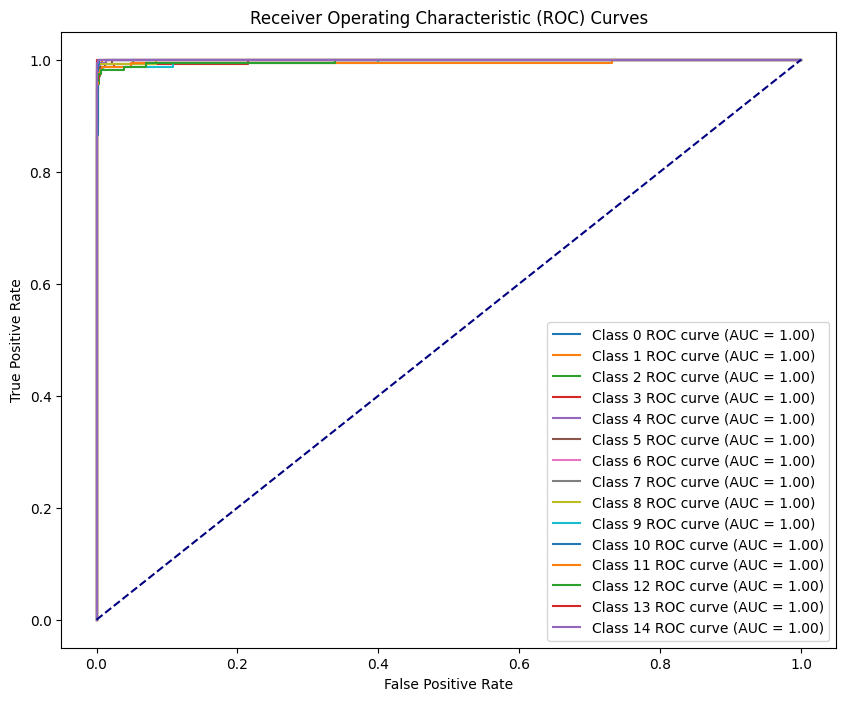

In [224]:
# Get model predictions

model_kan_save_path = 'best_kan_model.pth'
model_kan = ChineseCharacterCNN(True)
model_kan.load_state_dict(torch.load(model_kan_save_path))

y_pred = model_kan(test_x).detach().numpy()
y_true = test_y.detach().numpy()  # This is one-hot encoded ground truth

# Binarize the labels for multi-class ROC AUC calculation
y_true_bin = label_binarize(y_true, classes=[i for i in range(15)])  # Assuming 15 classes
n_classes = y_true_bin.shape[1]
# Calculate ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred[:, i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


### Linear

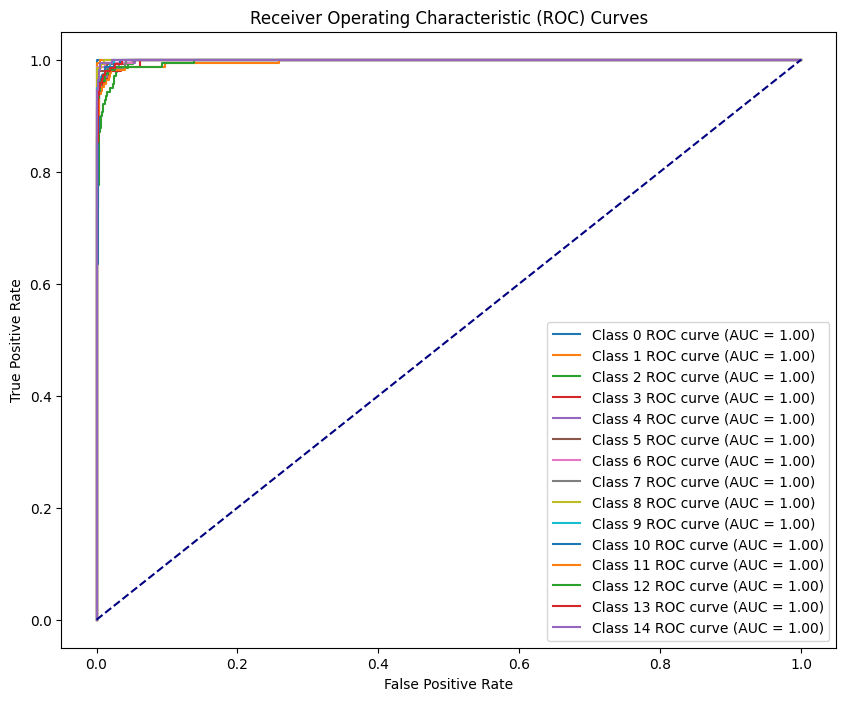

In [223]:
# Get model predictions

model_linear_save_path = 'best_linear_model.pth'
model_linear = ChineseCharacterCNN(False)
model_linear.load_state_dict(torch.load(model_linear_save_path))

y_pred = model_linear(test_x).detach().numpy()
y_true = test_y.detach().numpy()  # This is one-hot encoded ground truth

# Binarize the labels for multi-class ROC AUC calculation
y_true_bin = label_binarize(y_true, classes=[i for i in range(15)])  # Assuming 15 classes
n_classes = y_true_bin.shape[1]
# Calculate ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred[:, i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


## Classification Report ##

### Linear

In [233]:
model_linear_save_path = 'best_linear_model.pth'
model_linear = ChineseCharacterCNN(False)
model_linear.load_state_dict(torch.load(model_linear_save_path))
pred_linear = model_linear(test_x)

print('Classification Report Linear:\n\n',classification_report(test_y, torch.argmax(pred_linear, axis=1)))

Classification Report Linear:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       0.99      1.00      0.99       160
           2       0.98      0.98      0.98       139
           3       0.99      0.98      0.99       144
           4       1.00      0.99      0.99       161
           5       0.98      1.00      0.99       148
           6       1.00      1.00      1.00       150
           7       0.99      1.00      1.00       138
           8       0.99      1.00      1.00       137
           9       1.00      1.00      1.00       158
          10       0.98      0.99      0.98       148
          11       0.98      0.98      0.98       163
          12       0.99      0.97      0.98       159
          13       0.99      0.97      0.98       143
          14       0.98      1.00      0.99       165

    accuracy                           0.99      2250
   macro avg       0.99      0.99      0.99     

### KAN

In [234]:
model_kan_save_path = 'best_kan_model.pth'
model_kan = ChineseCharacterCNN(True)
model_kan.load_state_dict(torch.load(model_kan_save_path))
pred_kan = model_linear(test_x)

print('Classification Report KAN:\n\n',classification_report(test_y, torch.argmax(pred_kan, axis=1)))

Classification Report KAN:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       0.98      1.00      0.99       160
           2       0.99      0.99      0.99       139
           3       1.00      0.99      0.99       144
           4       0.98      0.99      0.98       161
           5       0.97      1.00      0.99       148
           6       0.99      1.00      1.00       150
           7       0.99      0.99      0.99       138
           8       0.99      0.99      0.99       137
           9       0.99      0.99      0.99       158
          10       0.96      0.97      0.97       148
          11       0.99      0.97      0.98       163
          12       0.98      0.95      0.96       159
          13       0.99      0.99      0.99       143
          14       0.99      0.98      0.98       165

    accuracy                           0.99      2250
   macro avg       0.99      0.99      0.99      22

## Confusion Matrix ##

### KAN

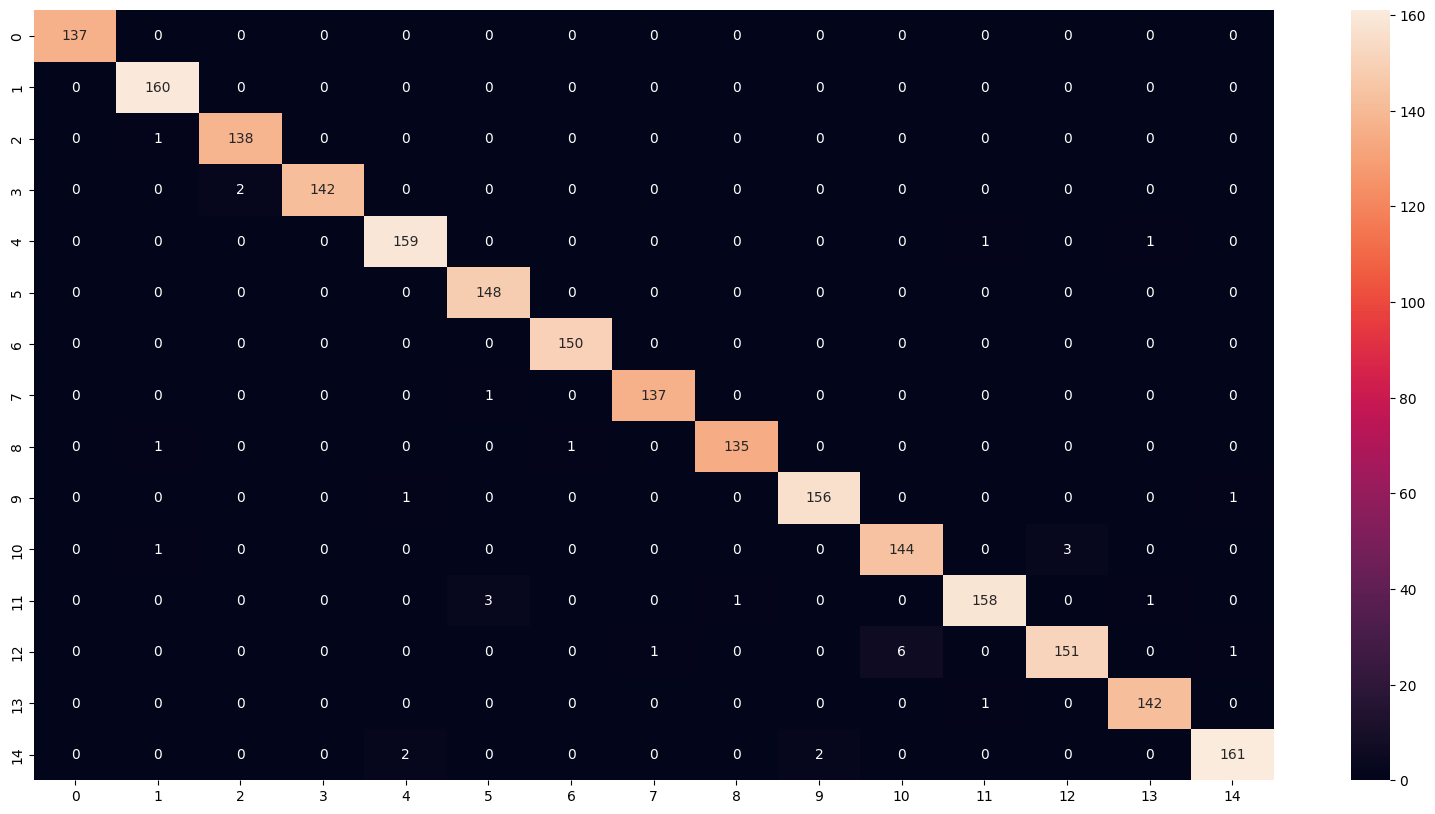

In [237]:
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(test_y, torch.argmax(pred_kan, axis=1)),annot=True,fmt='d')
plt.show()

### Linear

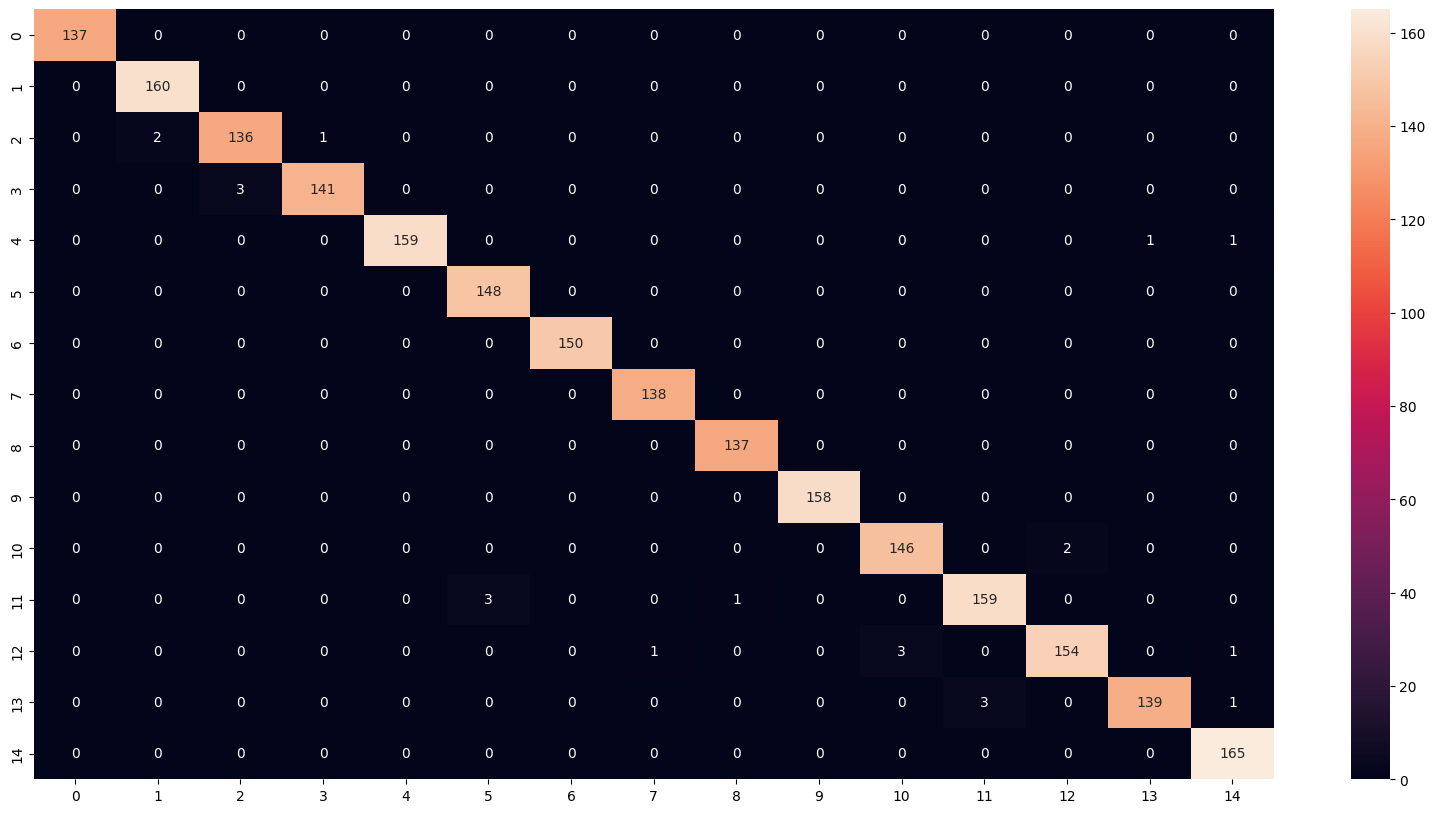

In [238]:
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(test_y, torch.argmax(pred_linear, axis=1)),annot=True,fmt='d')
plt.show()

## Accuracy,Precision,Recall and F1 Score ##

### KAN

In [241]:
print('Accuracy: ',accuracy_score(test_y,torch.argmax(pred_kan, axis=1)),'\n')
print('Precision: ',precision_score(test_y,torch.argmax(pred_kan, axis=1),average='micro'),'\n')
print('Recall: ',recall_score(test_y,torch.argmax(pred_kan, axis=1),average='micro'),'\n')
print('F1 Score: ',f1_score(test_y,torch.argmax(pred_kan, axis=1),average='micro'),'\n')

Accuracy:  0.9857777777777778 

Precision:  0.9857777777777778 

Recall:  0.9857777777777778 

F1 Score:  0.9857777777777778 



### Linear

In [242]:
print('Accuracy: ',accuracy_score(test_y,torch.argmax(pred_linear, axis=1)),'\n')
print('Precision: ',precision_score(test_y,torch.argmax(pred_linear, axis=1),average='micro'),'\n')
print('Recall: ',recall_score(test_y,torch.argmax(pred_linear, axis=1),average='micro'),'\n')
print('F1 Score: ',f1_score(test_y,torch.argmax(pred_linear, axis=1),average='micro'),'\n')

Accuracy:  0.9897777777777778 

Precision:  0.9897777777777778 

Recall:  0.9897777777777778 

F1 Score:  0.9897777777777778 



****
# Feedback and Suggestions #
****

**Kindly Provide feedback and suggestions to improve this notebook**

**Kindly Upvote if you found this notebook helpful or if you liked it :)**